## This notebook will be used to evaluate the differnce in performance when using less discriminant stats

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, entropy
from sklearn.tree import export_graphviz
from IPython.display import Image

from UtilFunctions import format_season

In [32]:
def pre_process(seasons, training_seasons):
    df = None
    for season in seasons:
        per_min_cols = ['FG', 'FTA', 'FT', 'STL', 'BLK', 'TRB', 'DRB', 'ORB', 'AST', 'TOV', 'PTS', 'PF', 'FGA', '3PA']
        first_year, second_year = format_season(season)
        player_data = pd.read_csv(f"DataCollection/Player_Stats/player_stats_{first_year}-{second_year}.csv")
        cols_to_keep = ['Player', 'Pos', 'Tm', 'G', 'MP', 'FG%', '3P', 'FG', 'FTA', 'FT', 'STL', 'BLK', 'TRB', 'DRB', 'ORB', 'AST', 'TOV', 'PTS', 'PF', 'FGA', '3PA', '3P%', '2P%', 'FT%']
            
        player_data = player_data.fillna(0)
        player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
        player_data = player_data.sort_values(by=['G'], ascending=False)
        player_data = player_data[player_data["Tm"] != "TOT"]
        player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
        player_data.reset_index(inplace=True)
        player_data = player_data[cols_to_keep]
        
        for col in per_min_cols:
            player_data[col] = player_data[col] / player_data['MP'] * 36
        
        if df is None:
            df = player_data
        else:
            df = pd.concat([df, player_data])
            
    df.reset_index(inplace=True)
    df.drop(['index', 'Player', 'Tm'], axis=1, inplace=True)
    return df

In [33]:
#teste de normalizar features
def random_forest_classify(X_train, y_train):
    rf = RandomForestClassifier()
    rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 30)},
                                 n_iter = 10, cv = 5, random_state=42)
    rand_search.fit(X_train, y_train)
    return rand_search.best_estimator_

In [34]:
def plot_feature_importances(importances, estimators, features):
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    #std = np.std([tree.feature_importances_ for tree in estimators], axis=0)
    fig, ax = plt.subplots(figsize=(18, 18))
    ax.bar(fi.index, fi)
    ax.tick_params('x', labelrotation=90)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")

In [35]:
def train_test_split(seasons, training_seasons):
    train_df = pre_process(seasons[:-1], training_seasons)
    test_df = pre_process(seasons[-1:], training_seasons)
    return train_df.loc[:, ~train_df.columns.isin(['Pos'])], test_df.loc[:, ~test_df.columns.isin(['Pos'])], train_df['Pos'], test_df['Pos']

In [36]:
def calculate_probability_matrix(cm):
    prob_matrix = []
    for i in range(len(cm)):
        prob_matrix.append([])
        players_in_position = sum(cm[i,:])
        for j in range(len(cm)):
            prob_matrix[i].append(round(cm[i,j]/players_in_position, 2))
    
    return prob_matrix

In [37]:
def entropy_by_position(positions, p_matrix):
    entropies = {}
    i = 0
    for position in positions:
        entropies[position] = entropy(p_matrix[i])
        i += 1
    return entropies

In [38]:
def classify_year_by_year(seasons, training_seasons=4):
    entropies_df = pd.DataFrame()
    f1_scores = pd.DataFrame()
    feature_importances = pd.DataFrame()
    confusion_matrices = {}
    accuracies = {}
    for season in seasons:
        X_train, X_test, y_train, y_test = train_test_split(range(season,season+training_seasons+1), training_seasons)
        rf = random_forest_classify(X_train, y_train)
        y_pred = rf.predict(X_test)
        labels = ["PG", "SG", "SF", "PF", "C"]
        cm = confusion_matrix(y_test, y_pred, labels=labels)
        prob_matrix = calculate_probability_matrix(cm)
        entropies_df[season+training_seasons] = entropy_by_position(labels, prob_matrix)
        f1_scores[season+training_seasons] = f1_score(y_test, y_pred, average='micro')
        confusion_matrices[season+training_seasons] = cm
        fi = {k:v for k,v in zip(X_train.columns,rf.feature_importances_)}
        feature_importances[season] = fi
        accuracies[season+training_seasons] = accuracy_score(y_test, y_pred)
    
    return entropies_df, f1_scores, feature_importances, confusion_matrices, accuracies

In [ ]:
stats_mapper = {
    'G': "Usage", 
    'MP': "Usage",
    'FG%': "Shooting",
    '3PM': "Shooting",
    'FGM': "Shooting",
    'FTA': "Usage",
    'FTM': "Shooting",
    'STL': "Defensive",
    'BLK': "Defensive",
    'TRB': "Rebounding",
    'DRB': "Rebounding",
    'ORB': "Rebounding",
    'AST': "Playmaking",
    'TOV': "Playmaking",
    'PTS': "Shooting",
    'PF': "Defensive",
    'FGA': "Usage",
    '3PA': "Usage",
    '3P%': "Shooting",
    '2P%': "Shooting",
    'FT%': "Shooting",
}

color_mapper = {
    "Usage": 'red',
    "Defensive": 'blue',
    "Shooting": 'green',
    "Rebounding": 'purple',
    "Playmaking": 'darkgoldenrod',
}


# 4 training seasons

In [40]:
entropies_df, scores, feature_importances, confusion_matrices, accuracies = classify_year_by_year(range(1980, 2021))

## Now let's find whether each combination fits the threshold for positionless

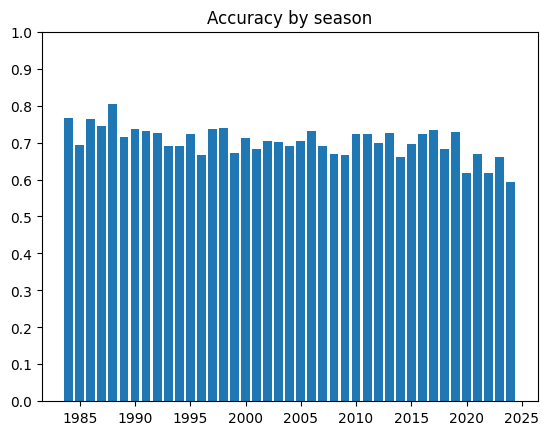

In [41]:
plt.bar(accuracies.keys(), accuracies.values())
plt.yticks(np.arange(0,1.1,0.1))
plt.title('Accuracy by season')
plt.show()

In [42]:
print(np.mean(list(accuracies.values())[:21]))
print(np.mean(list(accuracies.values())[21:]))
print(np.std(list(accuracies.values())))

0.7184407136276079
0.6861487492952388
0.040459133877794935


In [43]:
feature_importances_T = feature_importances.transpose()
mean_importances = feature_importances_T.mean()
mean_importances = mean_importances.sort_values(ascending=False)
filtered_indexes = mean_importances[mean_importances > 0.018].index.tolist()
print(filtered_indexes)

['AST', 'TRB', 'DRB', 'ORB', 'BLK', '3PA', 'STL', 'TOV', 'PF', 'FGA', '3P%', 'FG', 'FG%', 'FT%', '3P', 'PTS', 'MP', '2P%', 'FTA', 'FT', 'G']


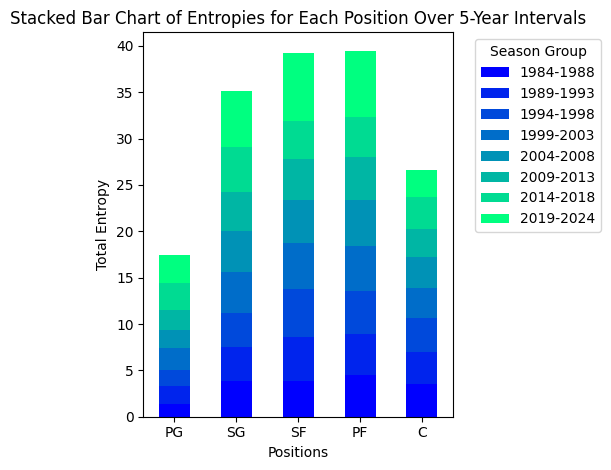

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming entropies_df is already loaded

# Define the number of years per group
group_size = 5

# Calculate the number of groups
num_groups = len(entropies_df.columns) // group_size

# Create a new DataFrame to store the grouped data
grouped_entropies_df = pd.DataFrame()

# Group the columns and sum the values
for i in range(num_groups - 1):  # Iterate up to the second-to-last group
    start_year = int(entropies_df.columns[i * group_size])
    end_year = int(entropies_df.columns[(i + 1) * group_size - 1])
    group_name = f'{start_year}-{end_year}'
    cols = entropies_df.columns[i * group_size:(i + 1) * group_size]
    grouped_entropies_df[group_name] = entropies_df[cols].sum(axis=1)

# Handle the last group, merging the remaining years
start_year = int(entropies_df.columns[(num_groups - 1) * group_size])
end_year = int(entropies_df.columns[-1])
group_name = f'{start_year}-{end_year}'
cols = entropies_df.columns[(num_groups - 1) * group_size:]
grouped_entropies_df[group_name] = entropies_df[cols].sum(axis=1)

# Define a color scale
num_colors = len(grouped_entropies_df.columns)
color_scale = plt.cm.winter(np.linspace(0, 1, num_colors))  # Alternative: 'cool'

# Plot the grouped data with the color scale
grouped_entropies_df.plot(kind='bar', stacked=True, color=color_scale)

plt.title('Stacked Bar Chart of Entropies for Each Position Over 5-Year Intervals')
plt.xlabel('Positions')
plt.ylabel('Total Entropy')
plt.xticks(rotation=0)
plt.legend(title='Season Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.savefig('PositionlessArticle/AccumulatedEntropyByPosition.png', bbox_inches='tight')
plt.show()

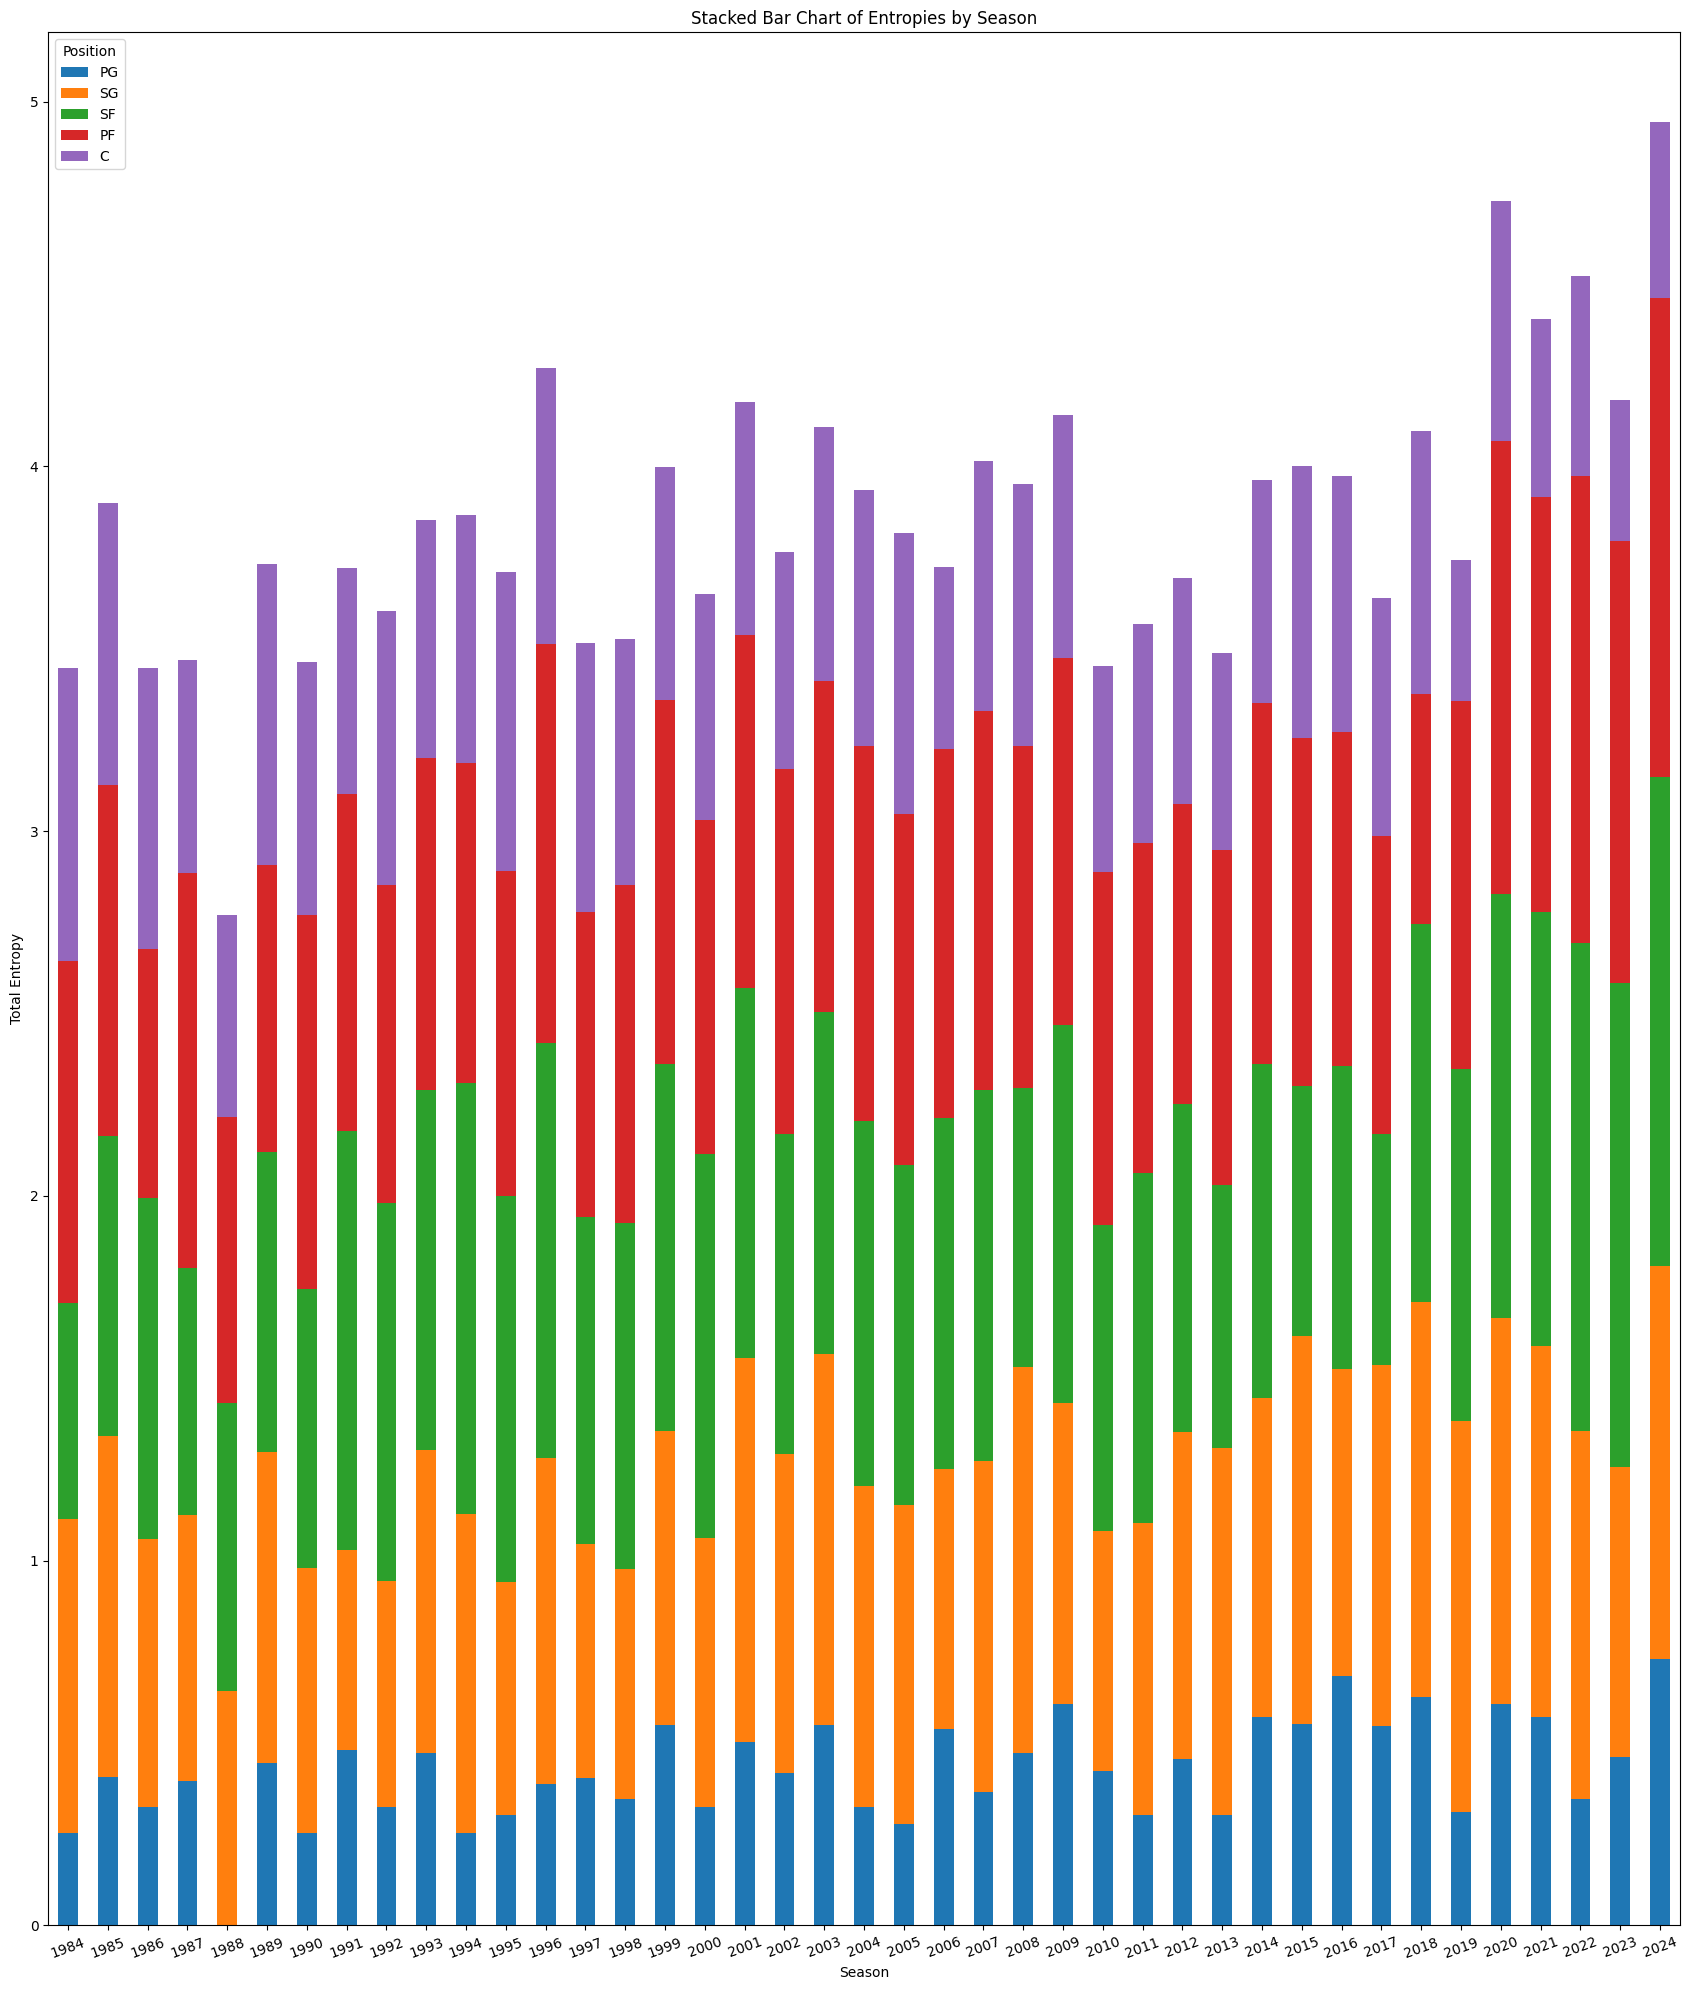

In [45]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

plt.title('Stacked Bar Chart of Entropies by Season')
plt.xlabel('Season')
plt.ylabel('Total Entropy')
plt.xticks(rotation=20)
plt.legend(title='Position', loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
plt.savefig('PositionlessArticle/AccumulatedEntropyBySeason.png', bbox_inches='tight')
plt.show()
# WILL BE USED IN THE ARTICLE

KeyError: '3P'

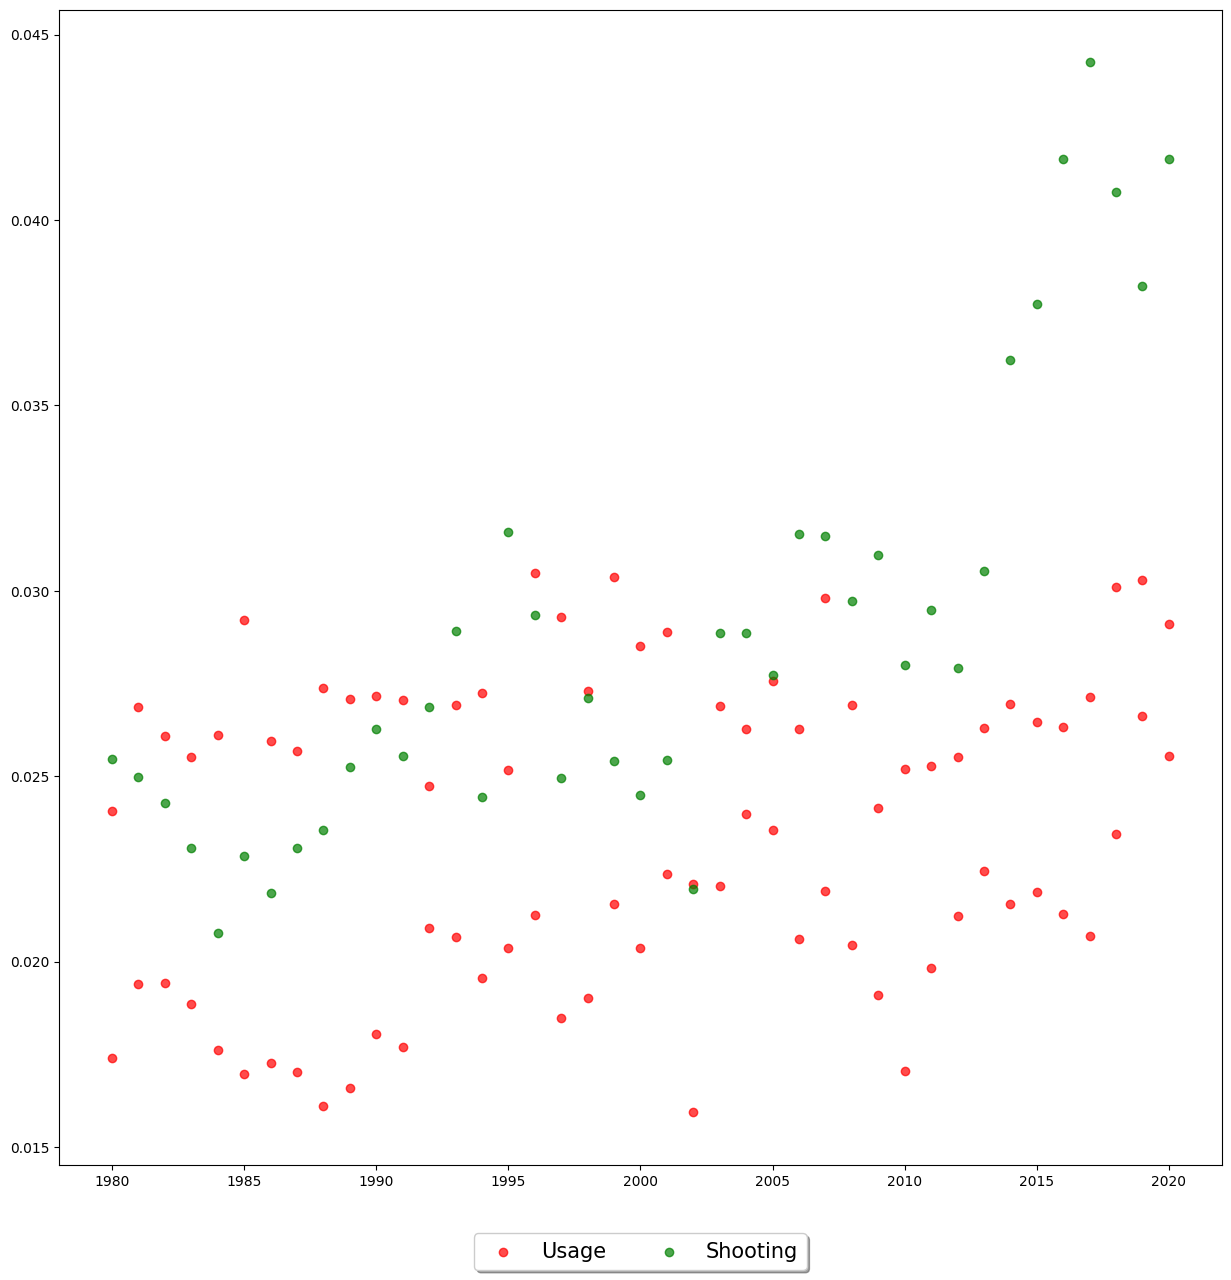

In [46]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3, prop={'size': 15})

plt.show()
#MIGHT USE

## Run NullHypothesis notebook to find positionless borderlines

In [ ]:
import nbformat
from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [ ]:
with open("NullHypothesisClassifier__.ipynb", "r") as f:
    notebook = nbformat.read(f, as_version=4)

# Create an interactive shell
shell = InteractiveShell.instance()

# Execute each cell in the notebook
for cell in notebook.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900


In [ ]:
transposed_entropies = entropies_df.transpose()
positionless_markers = {}

for i, row in transposed_entropies.iterrows():
    positionless_markers[i] = {}
    for position in POSITIONS:
        if row[position] > positionless_borderlines[i][position]:
            positionless_markers[i][position] = True
        else:
            positionless_markers[i][position] = False

    

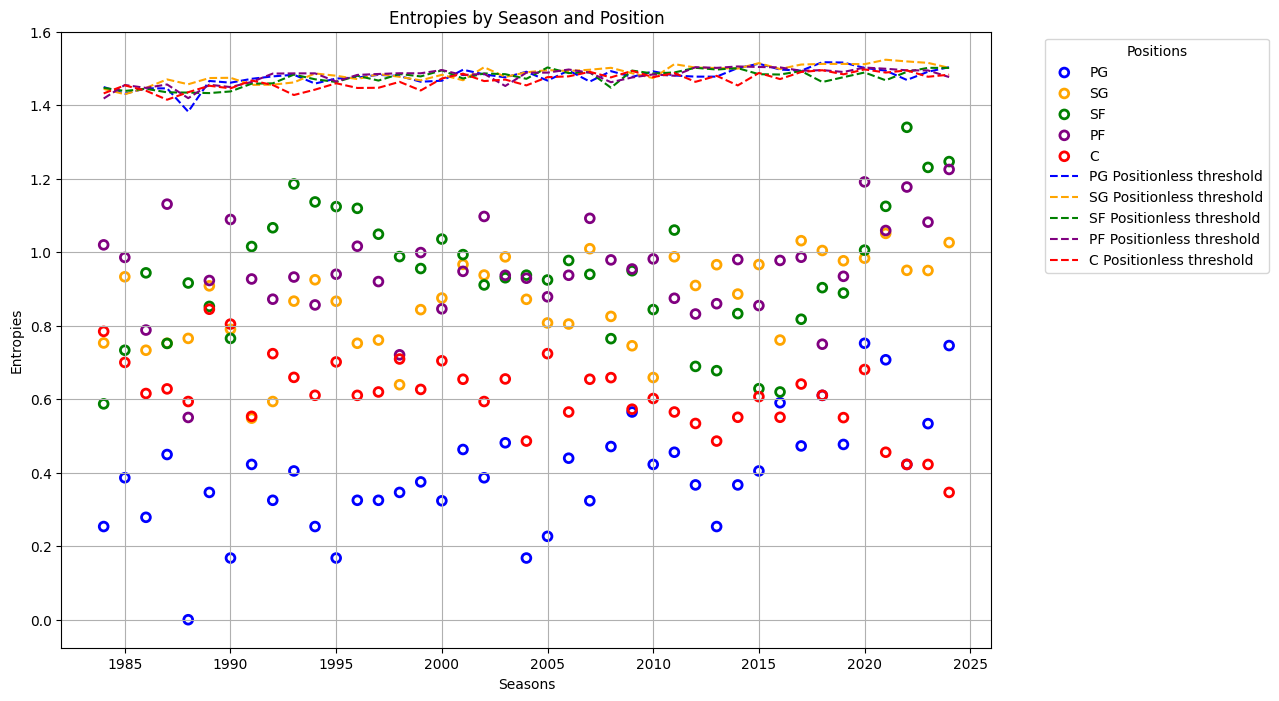

In [ ]:
seasons = transposed_entropies.index
positions = transposed_entropies.columns

# Create the scatter plot
plt.figure(figsize=(12, 8))

for season in seasons:
    colors = {'PG': 'b', 'SG': 'orange', 'SF': 'g', 'PF': 'purple', 'C': 'r'}
    for position in positions:
        entropy = transposed_entropies.loc[season, position]
        fill_style = 'full' if positionless_markers[season][position] else 'none'
        
        plt.scatter(season, entropy, label=position, edgecolor=colors[position], facecolor=colors[position] if fill_style == 'full' else 'none', marker='o', s=40, lw=2)

for position in positions:
    borderlines = [positionless_borderlines[season][position] for season in seasons]
    plt.plot(seasons, borderlines, label=f'{position} Positionless threshold', color=colors[position], linestyle='--')

# Customize the plot
plt.xlabel('Seasons')
plt.ylabel('Entropies')
plt.title('Entropies by Season and Position')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys(), title='Positions', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True)
plt.show()
# WILL BE USED IN THE ARTICLE

# 5 training seasons

c:\Users\mathe\anaconda3\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:136: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


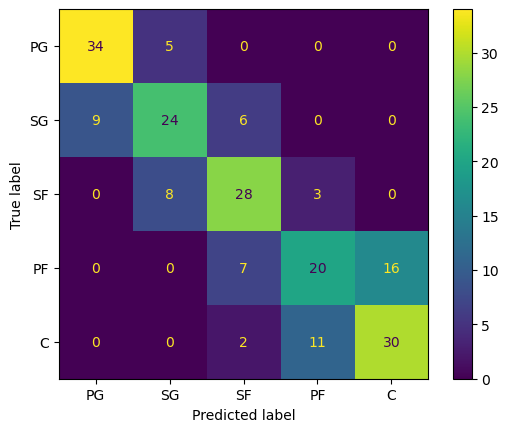

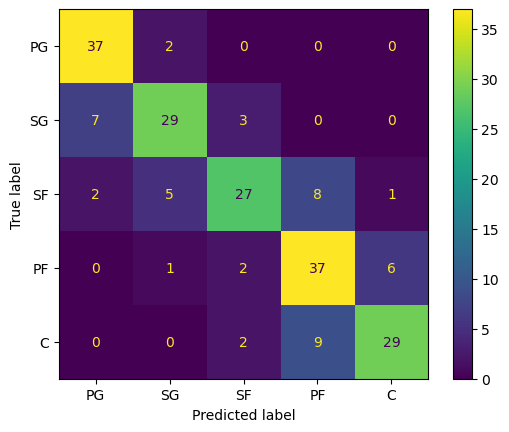

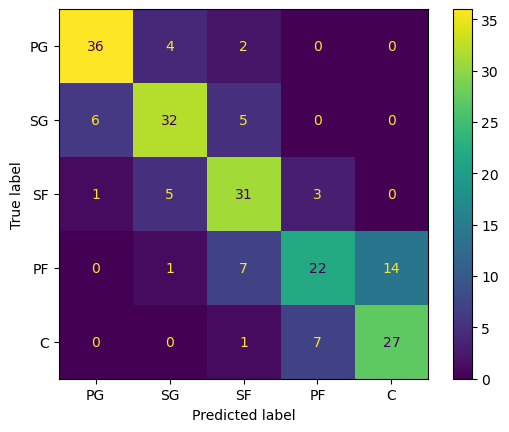

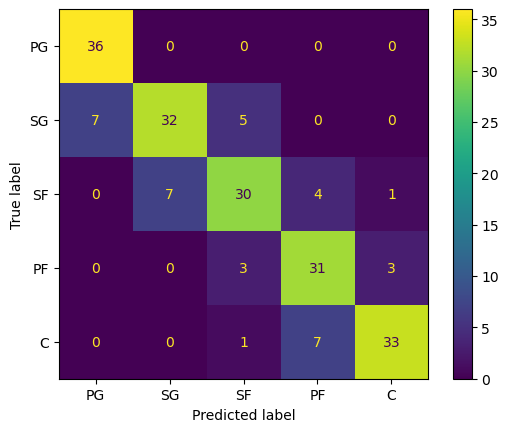

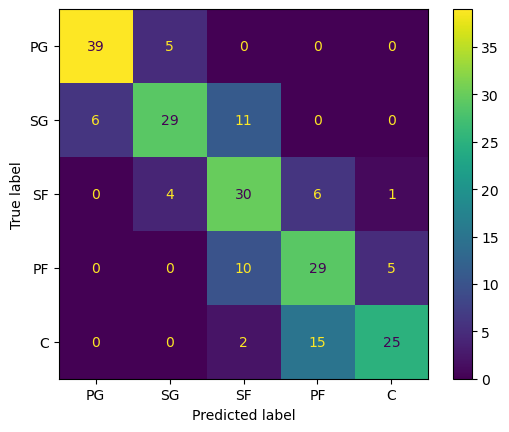

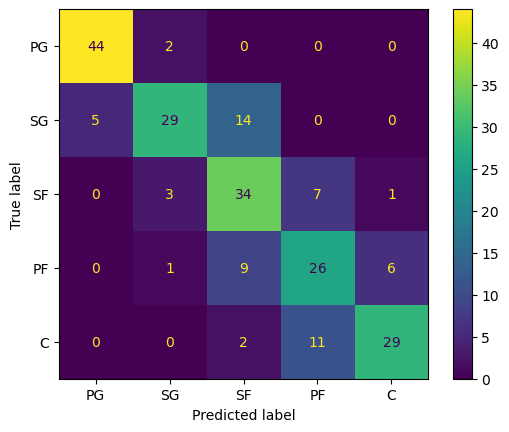

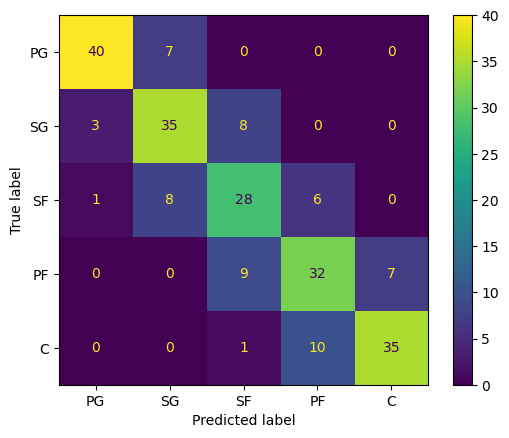

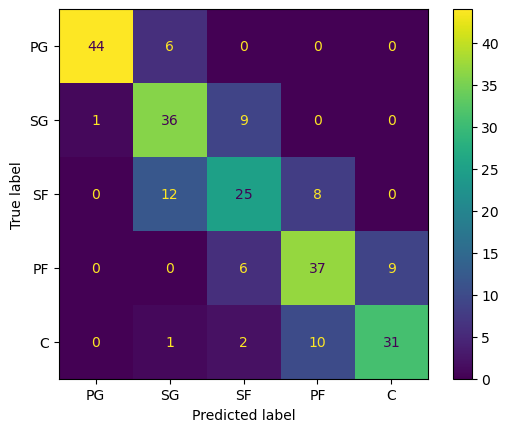

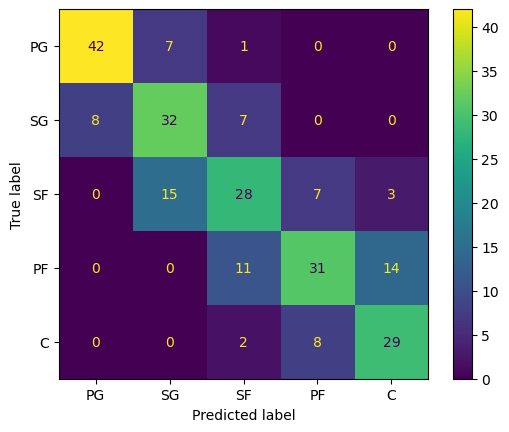

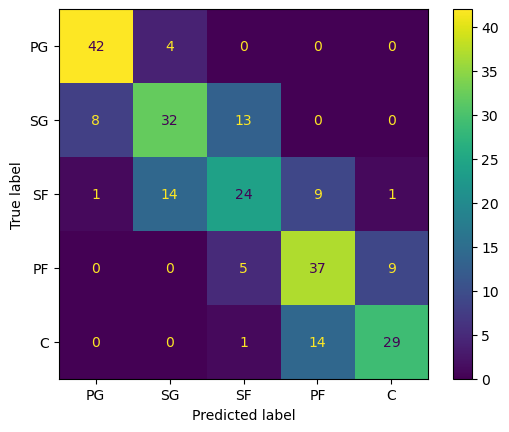

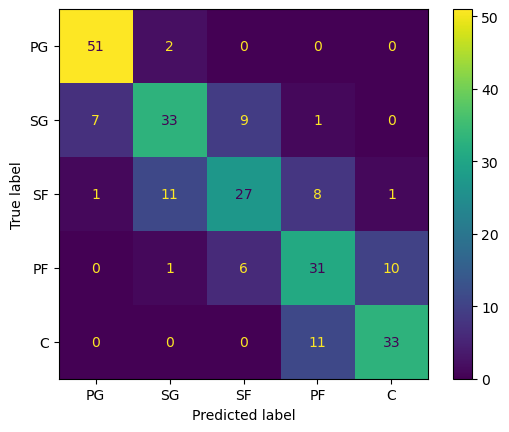

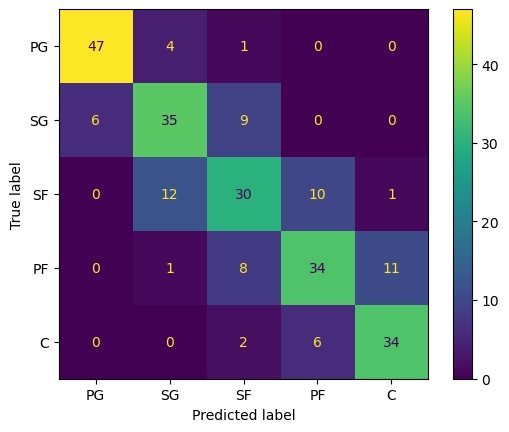

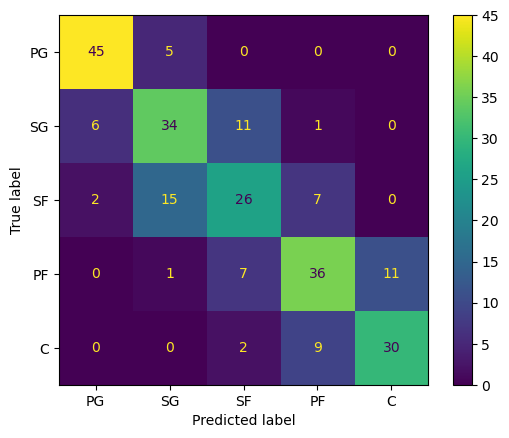

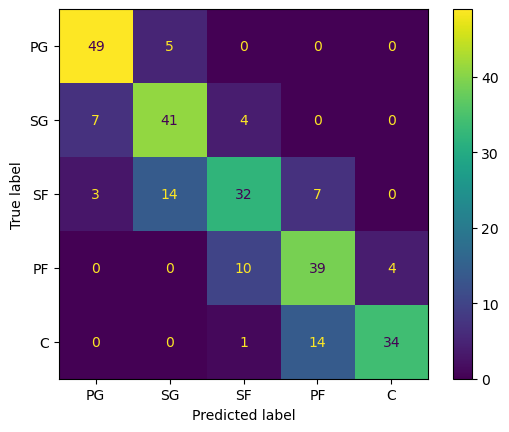

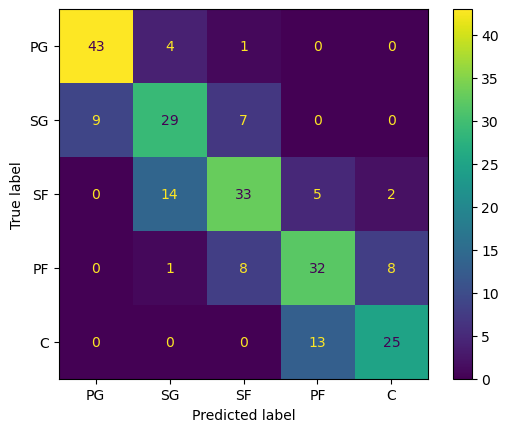

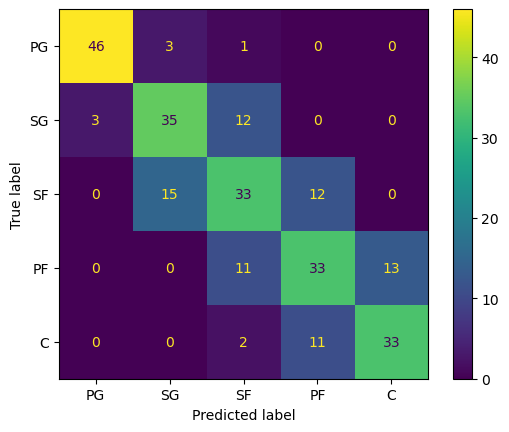

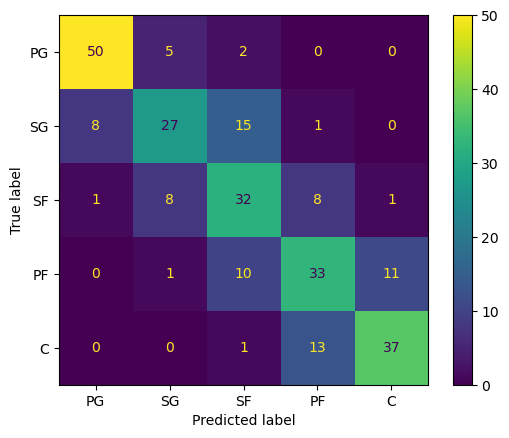

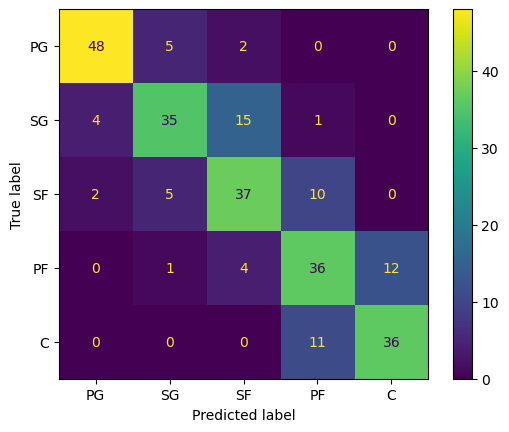

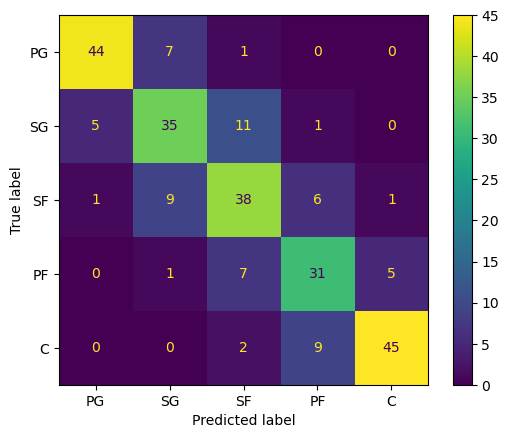

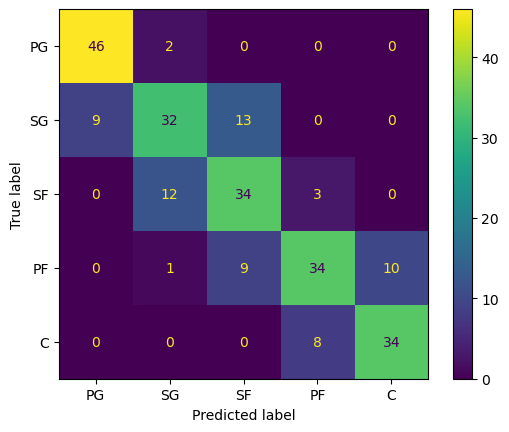

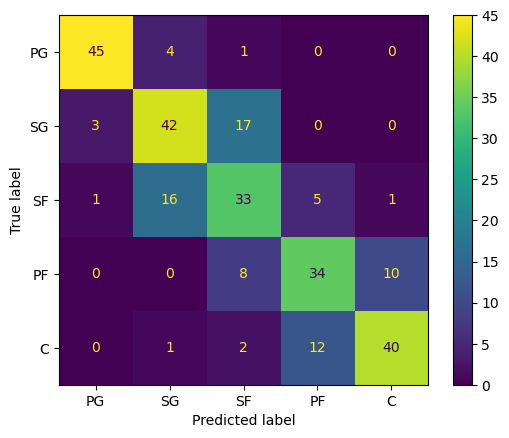

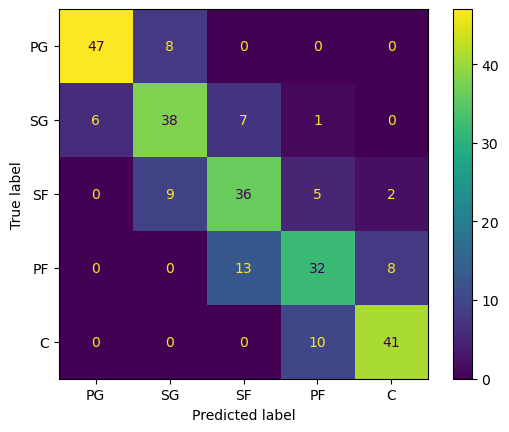

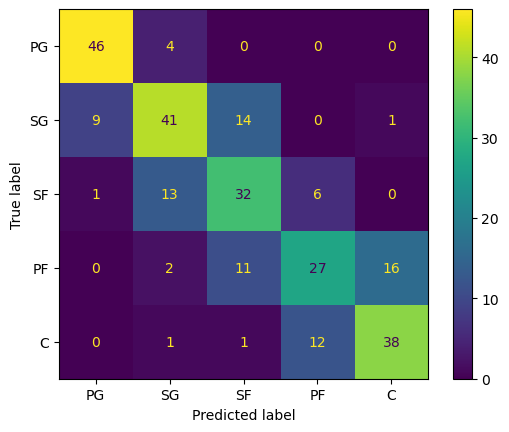

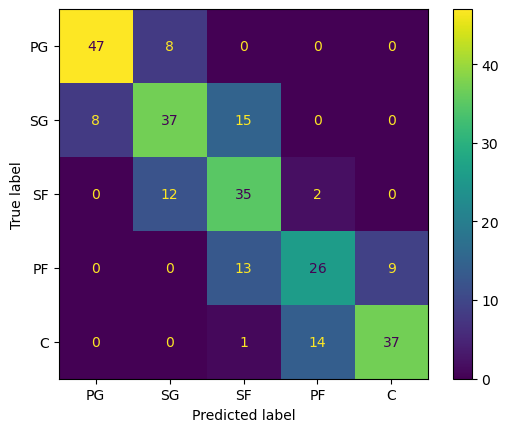

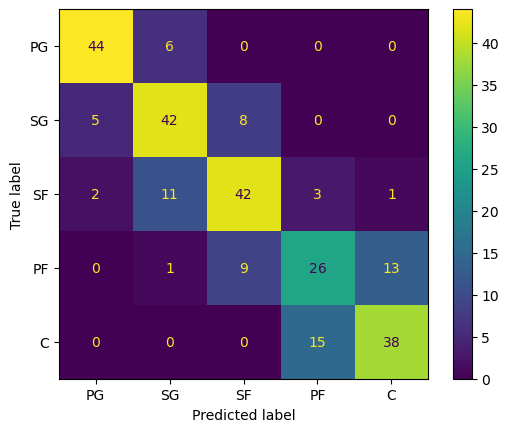

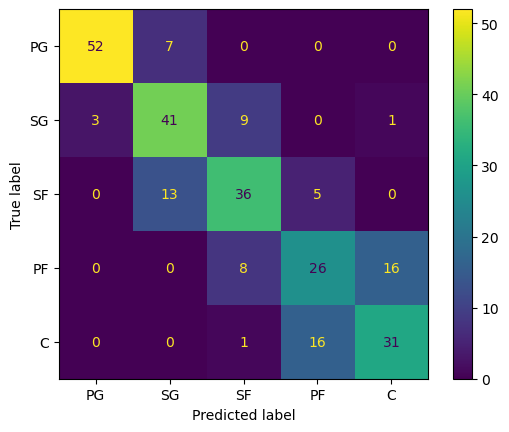

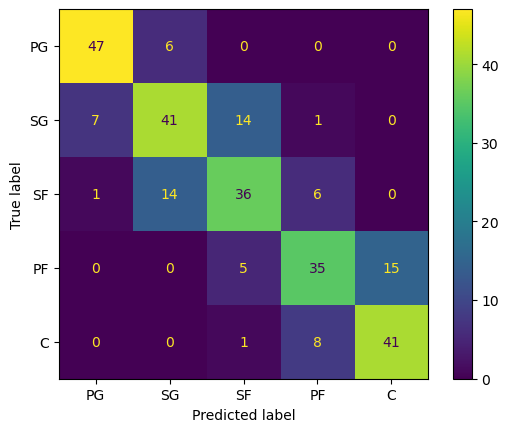

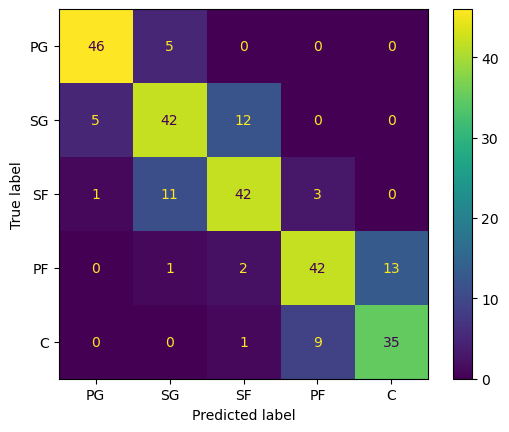

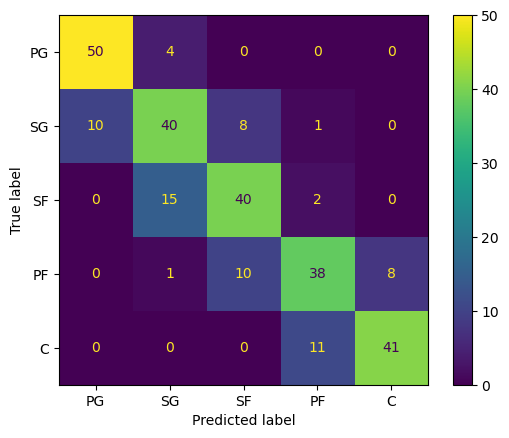

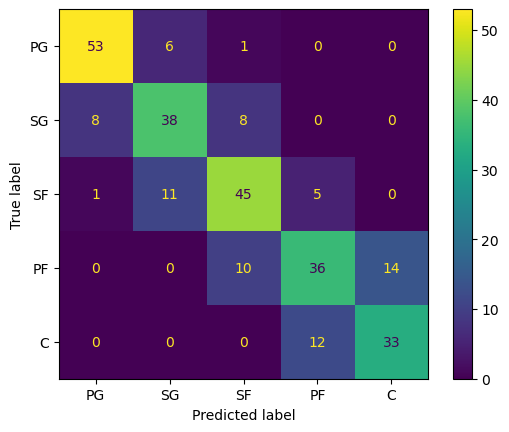

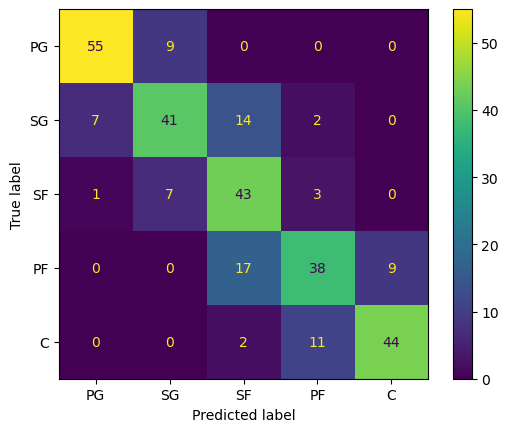

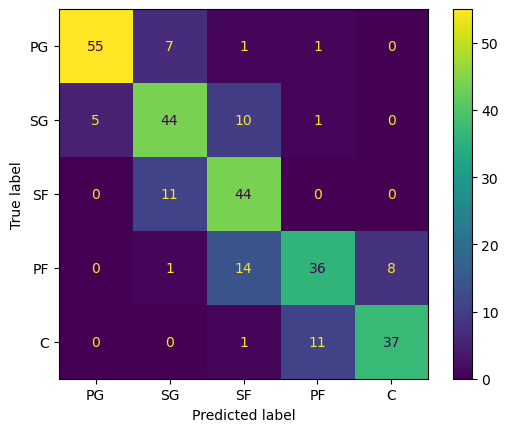

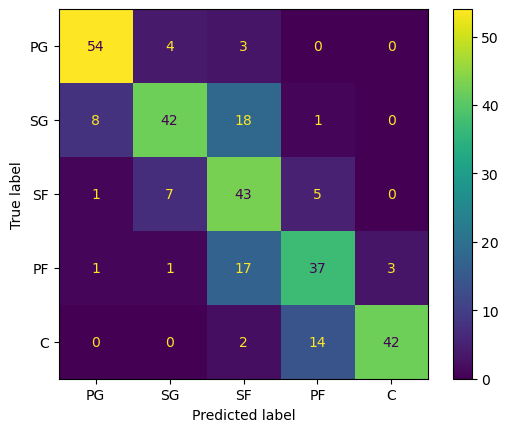

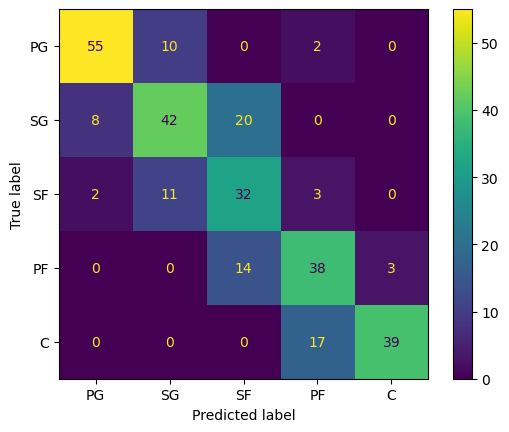

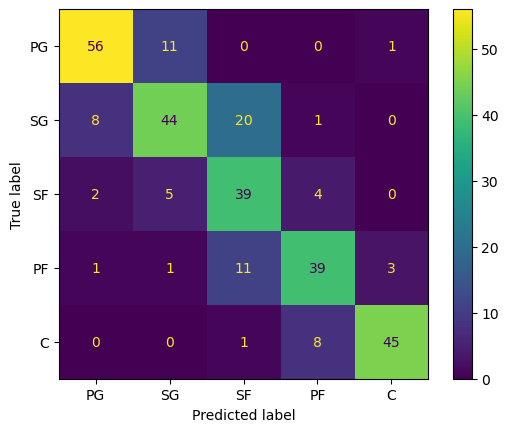

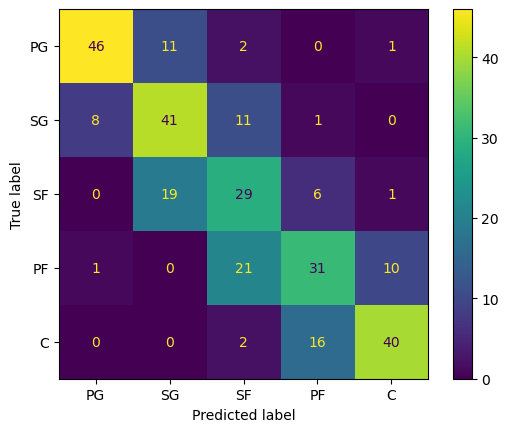

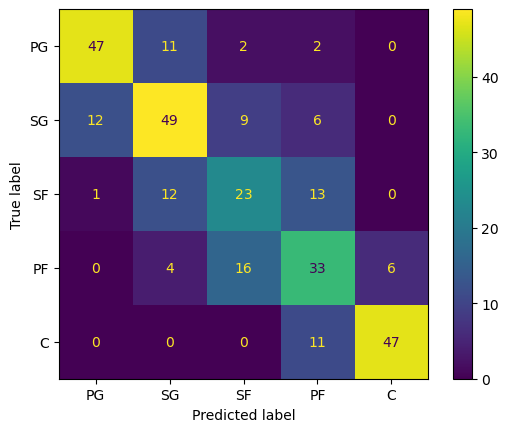

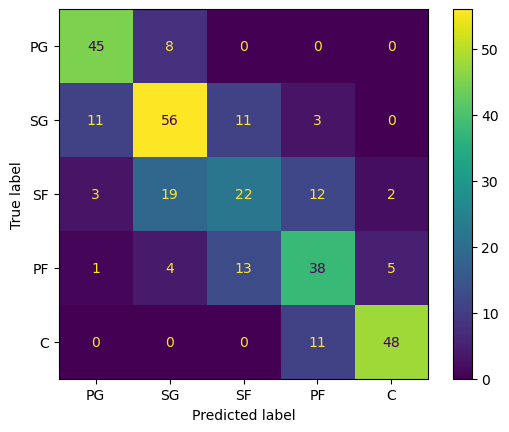

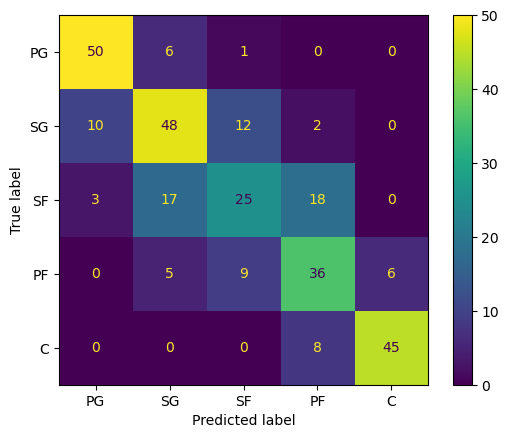

In [ ]:
entropies_df, scores, feature_importances = classify_year_by_year(range(1980, 2019), 5)

<Axes: >

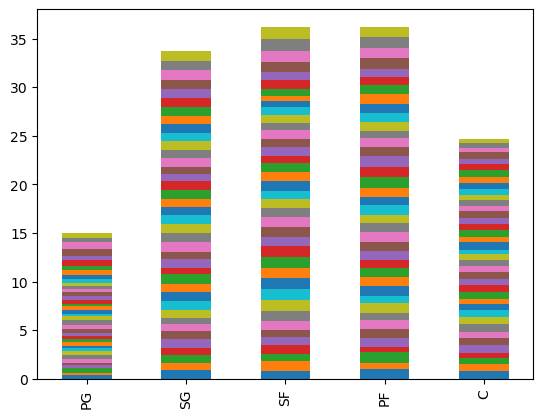

In [ ]:
entropies_df.plot(kind='bar', stacked=True, legend=False)

<Axes: >

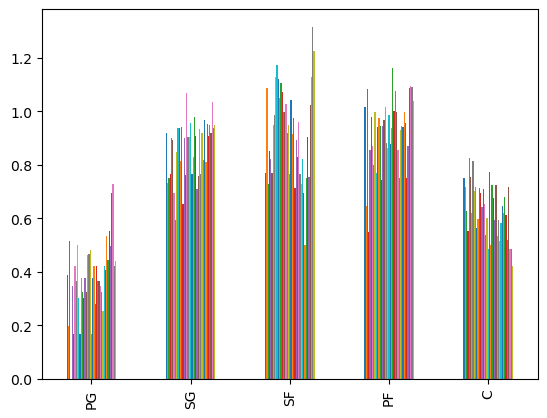

In [ ]:
entropies_df.plot(kind='bar', legend=False)

<Axes: >

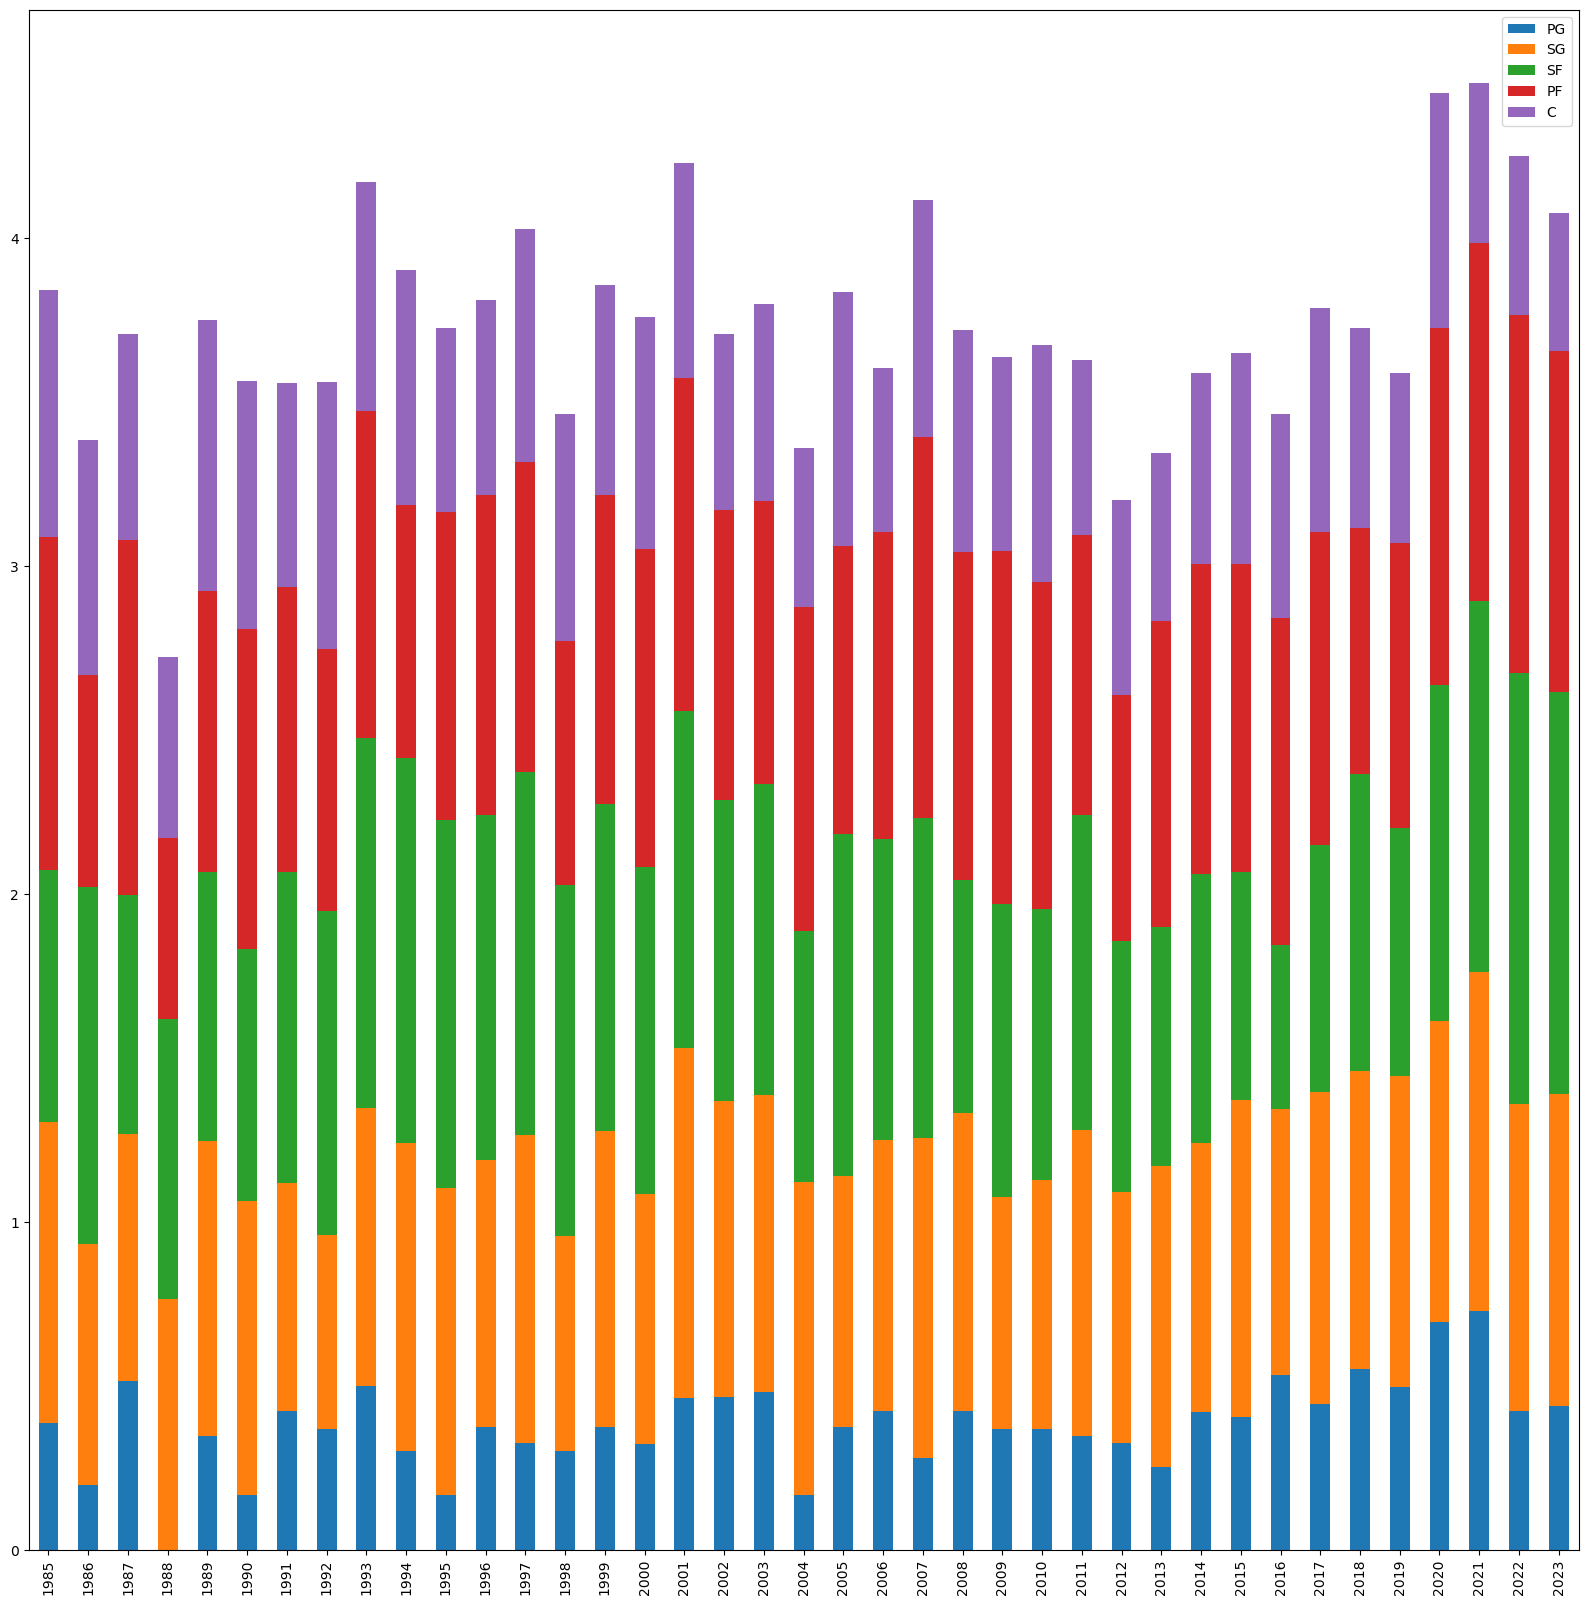

In [ ]:
entropies_df.transpose().plot(kind='bar', stacked=True, figsize=(20,20))

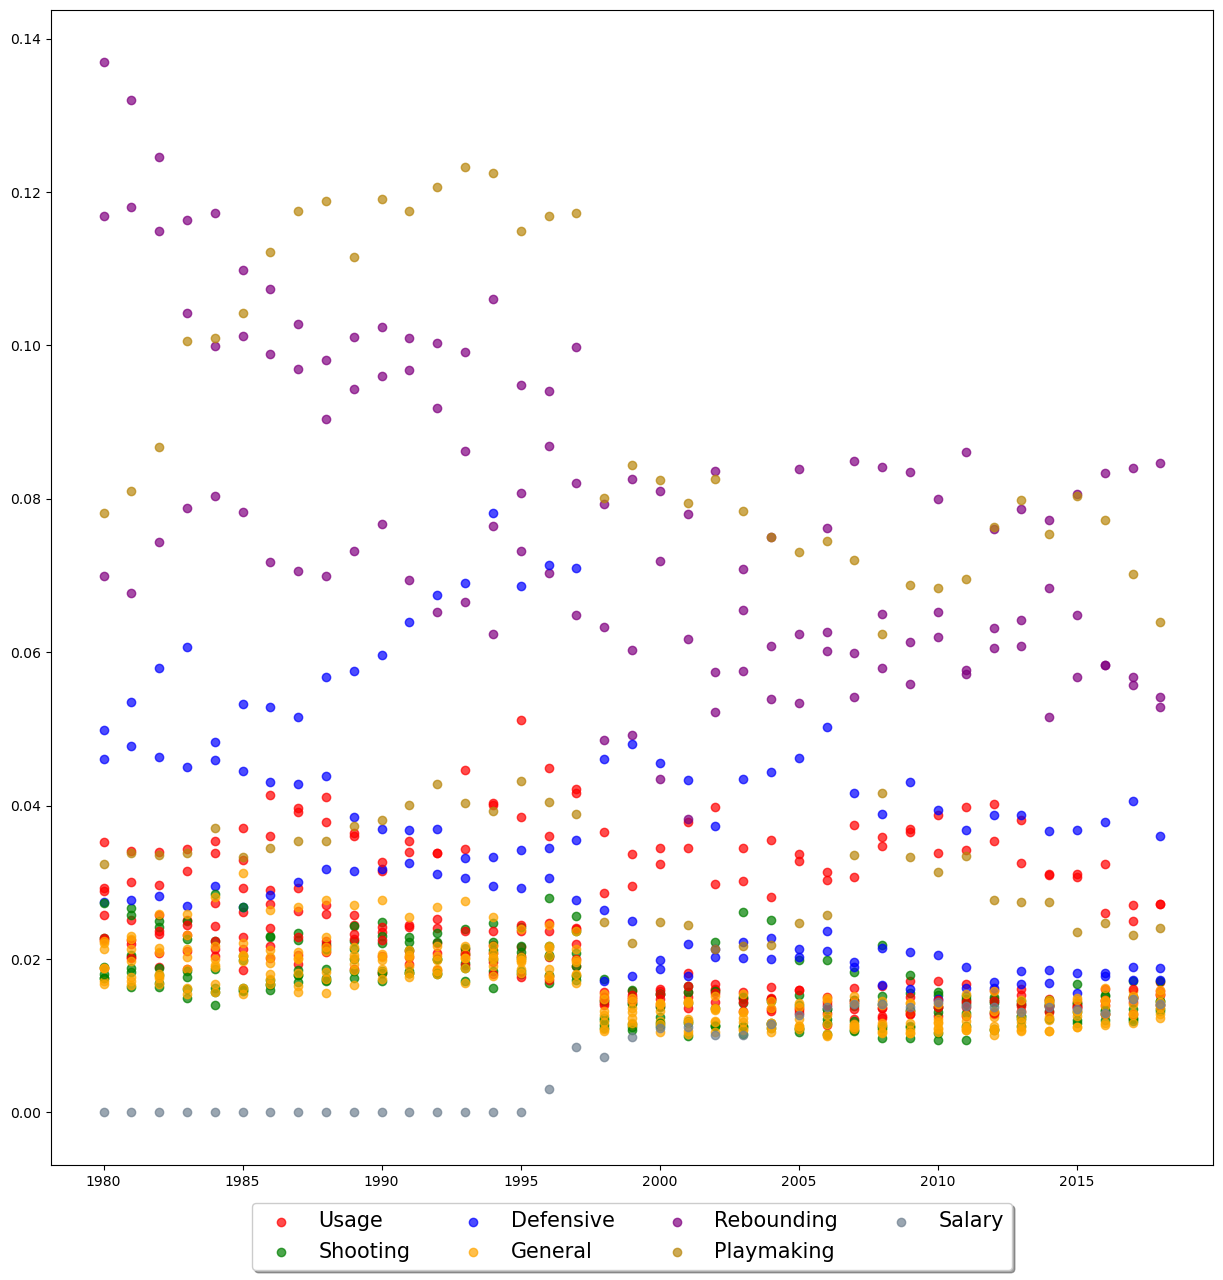

In [ ]:
plt.figure(figsize=(15,15))

for idx in feature_importances.index:
    plt.scatter(feature_importances.columns, feature_importances.loc[idx], label=stats_mapper[idx], color=color_mapper[stats_mapper[idx]], alpha=0.7)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(),loc='lower center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=4, prop={'size': 15})

plt.show()

In [ ]:
transposed = entropies_df.transpose()
transposed.describe()

,PG,SG,SF,PF,C
count,39.000000,39.000000,39.000000,39.000000,39.000000
mean,0.383358,0.863798,0.928511,0.928031,0.632844
std,0.137921,0.106324,0.172425,0.128236,0.099306
min,0.000000,0.593928,0.500402,0.550573,0.422709
25%,0.324420,0.765655,0.768609,0.866191,0.557955
50%,0.375123,0.903532,0.948528,0.945366,0.628335
75%,0.454313,0.937019,1.047423,0.999837,0.714634
max,0.727629,1.066923,1.316260,1.160377,0.825868
